# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Constants

In [2]:
dataset_paths = [
    '/kaggle/input/zocdoc/new_jersey.csv',
    '/kaggle/input/zocdoc/new_jersey_cardiologist.csv',
    '/kaggle/input/zocdoc/new_jersey_chiropractor.csv',
    '/kaggle/input/zocdoc/new_jersey_dentist.csv',
    '/kaggle/input/zocdoc/new_jersey_dermatologist.csv',
    '/kaggle/input/zocdoc/new_jersey_dietitian.csv',
    '/kaggle/input/zocdoc/new_jersey_ent.csv',
    '/kaggle/input/zocdoc/new_jersey_gastroenterologist.csv',
    '/kaggle/input/zocdoc/new_jersey_neurosurgeon.csv',
    '/kaggle/input/zocdoc/new_jersey_ob-gyn.csv',
    '/kaggle/input/zocdoc/new_jersey_oncologist.csv',
    '/kaggle/input/zocdoc/new_jersey_optometrist.csv',
    '/kaggle/input/zocdoc/new_jersey_orthopedic.csv',
    '/kaggle/input/zocdoc/new_jersey_orthopedic_surgeon.csv',
    '/kaggle/input/zocdoc/new_jersey_pain_management.csv',
    '/kaggle/input/zocdoc/new_jersey_physical_therapist.csv',
    '/kaggle/input/zocdoc/new_jersey_podiatrist.csv',
    '/kaggle/input/zocdoc/new_jersey_primary_care_physician.csv',
    '/kaggle/input/zocdoc/new_jersey_psychiatrist.csv',
    '/kaggle/input/zocdoc/new_jersey_rheumatologist.csv',
    '/kaggle/input/zocdoc/new_jersey_sports_medicine_specialist.csv',
    '/kaggle/input/zocdoc/new_jersey_surgeon.csv'
]

# Utils

In [25]:
def get_data_file_paths():
    file_paths = []
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            file_paths.append(path)
    return sorted(file_paths)


def clean_dataset(path, speciality):
    # 1. Read dataset
    df = pd.read_csv(path)

    # 2. Drop duplicates
    df = df.drop_duplicates()

    # 3. Extract Drs
    df_drs = df[df['name'].str.lower().str.contains('dr')]
    df_drs = df_drs[df_drs['job_title'].str.lower().str.contains(f'{speciality}|internist')]
    df_drs = df_drs.assign(is_dr=1, is_nurse=0, is_assistant=0)

    # 4. Extract Non. Drs and assign nurse and assistants status to them
    df_no_drs = df[~df['name'].str.lower().str.contains('dr')]
    df_no_drs = df_no_drs.assign(is_dr=0, is_nurse=0, is_assistant=0)
    df_no_drs.loc[df_no_drs['job_title'].str.lower().str.contains('nurse'), 'is_nurse'] = 1
    df_no_drs.loc[df_no_drs['job_title'].str.lower().str.contains('assistant'), 'is_assistant'] = 1
    print(f"Count non-assigned status rows: {len(df_no_drs[(df_no_drs['is_nurse']==0) & (df_no_drs['is_assistant']==0)])}")

    # 5. Combined both the dr and non-drs rows
    df_combined = pd.concat([df_drs, df_no_drs], ignore_index=True)
    
    # 6. Set 'job_title' to speciality name
    print(f"\n[Before] Job title unique values: {df_combined['job_title'].value_counts()}")
    df_combined['job_title'] = speciality
    
    # 7. Merge 'location_name' and 'street_address'
    df_combined['street_address'] = df_combined['location_name'].fillna('') + ' ' + df_combined['street_address'].fillna('')
    df_combined['street_address'] = df_combined['street_address'].str.strip()
    df_combined = df_combined.drop(columns=['location_name']) # Remove dedundant column

    # 8. Impute 'region' and 'postal_code' with their mode
    mode_region = df_combined['region'].mode()[0]
    mode_postal_code = df_combined['postal_code'].mode()[0]
    df_combined['region'] = df_combined['region'].fillna(mode_region)
    df_combined['postal_code'] = df_combined['postal_code'].fillna(mode_postal_code)
    
    # 9. Change column with object types to case
    df_combined['name'] = df_combined['name'].str.lower()
    df_combined['job_title'] = df_combined['job_title'].str.lower()
    df_combined['street_address'] = df_combined['street_address'].str.lower()
    df_combined['address_locality'] = df_combined['address_locality'].str.lower()
    df_combined['region'] = df_combined['region'].str.upper()
    
    # 10. Change 'postal_code' column type
    df_combined['postal_code'] = df_combined['postal_code'].astype(int)
    
    print(f"\n[After] Job title unique values: {df_combined['job_title'].value_counts()}")
    
    return df_combined


def clean_chiropractor(path, speciality):
    pass

def check_plots(dataset):
    sns.countplot(y='job_title', data=dataset, order=dataset['job_title'].value_counts().index)
    plt.title('Distribution of Job Titles')
    plt.xlabel('Count')
    plt.ylabel('Job Title')
    plt.show()
    
    sns.countplot(y='region', data=dataset, order=dataset['region'].value_counts().index)
    plt.title('Distribution of Region')
    plt.xlabel('Count')
    plt.ylabel('Region')
    plt.show()

# Code

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Cardiologist                        130
Nurse Practitioner (Cardiology)       9
Physician Assistant (Cardiology)      7
Family Nurse Practitioner             4
Nurse Practitioner                    1
Adult Nurse Practitioner              1
Physician Assistant                   1
Name: count, dtype: int64

[After] Job title unique values: job_title
cardiologist    153
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              153 non-null    object 
 1   job_title         153 non-null    object 
 2   rating            150 non-null    float64
 3   street_address    153 non-null    object 
 4   address_locality  151 non-null    object 
 5   region            153 non-null    object 
 6   postal_code       153 non-null    int64

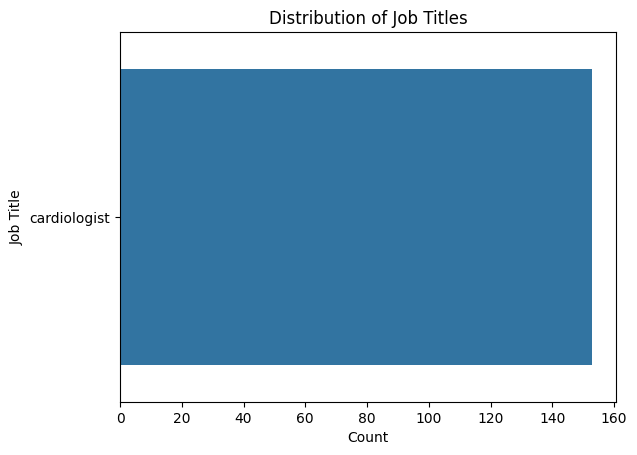

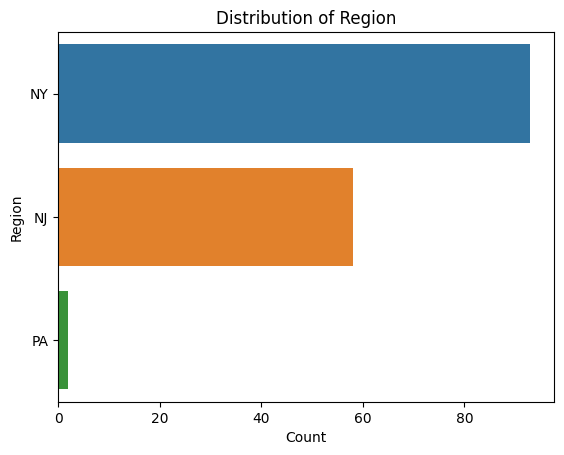

In [26]:
df_cardiologist = clean_dataset(dataset_paths[1], 'cardiologist')
df_cardiologist.info()
check_plots(df_cardiologist)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Chiropractor    150
Internist         7
Name: count, dtype: int64

[After] Job title unique values: job_title
chiropractor    157
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              157 non-null    object 
 1   job_title         157 non-null    object 
 2   rating            148 non-null    float64
 3   street_address    157 non-null    object 
 4   address_locality  155 non-null    object 
 5   region            157 non-null    object 
 6   postal_code       157 non-null    int64  
 7   is_dr             157 non-null    int64  
 8   is_nurse          157 non-null    int64  
 9   is_assistant      157 non-null    int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 12.4+ KB


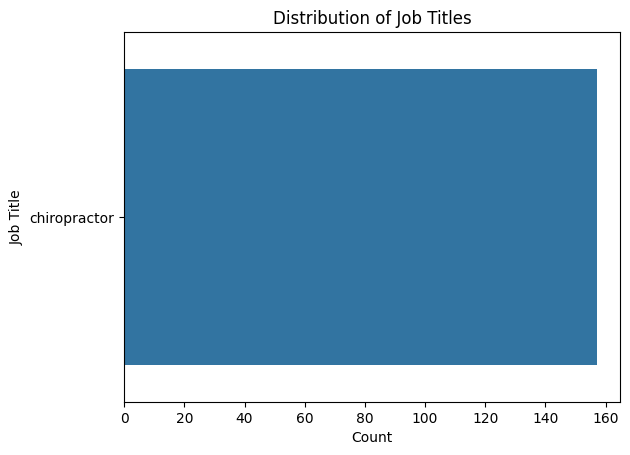

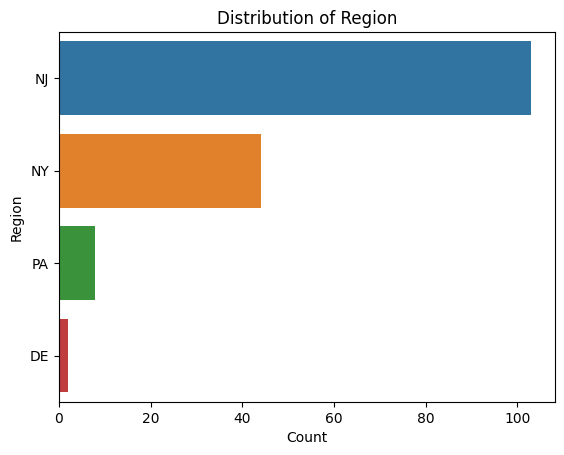

In [27]:
df_chiropractor = clean_dataset(dataset_paths[2], 'chiropractor')
df_chiropractor.info()
check_plots(df_chiropractor)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Dentist    155
Name: count, dtype: int64

[After] Job title unique values: job_title
dentist    155
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              155 non-null    object 
 1   job_title         155 non-null    object 
 2   rating            150 non-null    float64
 3   street_address    155 non-null    object 
 4   address_locality  154 non-null    object 
 5   region            155 non-null    object 
 6   postal_code       155 non-null    int64  
 7   is_dr             155 non-null    int64  
 8   is_nurse          155 non-null    int64  
 9   is_assistant      155 non-null    int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 12.2+ KB


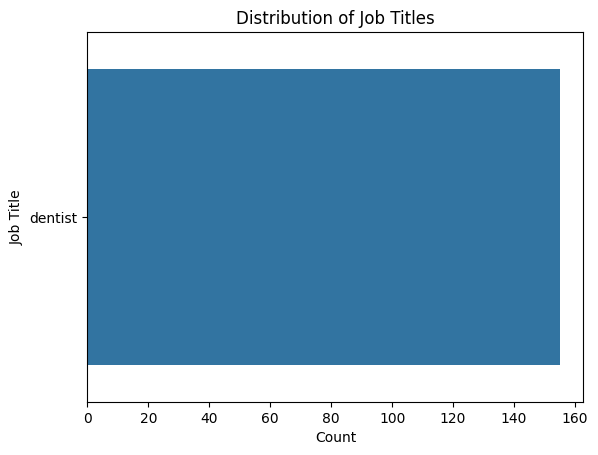

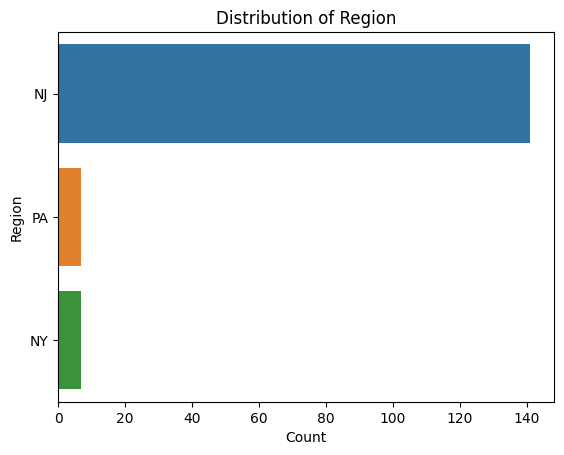

In [31]:
df_dentist = clean_dataset(dataset_paths[3], 'dentist')
df_dentist.info()
check_plots(df_dentist)

In [28]:
# 1. Read dataset
df = pd.read_csv(dataset_paths[3])

# 2. Drop duplicates
df = df.drop_duplicates()

# 3. Extract Drs
df_drs = df[df['name'].str.lower().str.contains('dr')]
df_drs = df_drs[df_drs['job_title'].str.lower().str.contains('dentist|internist')]
df_drs = df_drs.assign(is_dr=1, is_nurse=0, is_assistant=0)

# 4. Extract Non. Drs and assign nurse and assistants status to them
df_no_drs = df[~df['name'].str.lower().str.contains('dr')]
df_no_drs = df_no_drs.assign(is_dr=0, is_nurse=0, is_assistant=0)
df_no_drs.loc[df_no_drs['job_title'].str.lower().str.contains('nurse'), 'is_nurse'] = 1
df_no_drs.loc[df_no_drs['job_title'].str.lower().str.contains('assistant'), 'is_assistant'] = 1
print(f"Count non-assigned status rows: {len(df_no_drs[(df_no_drs['is_nurse']==0) & (df_no_drs['is_assistant']==0)])}")

# # 5. Combined both the dr and non-drs rows
# df_combined = pd.concat([df_drs, df_no_drs], ignore_index=True)

# # 6. Set 'job_title' to speciality name
# print(f"\n[Before] Job title unique values: {df_combined['job_title'].value_counts()}")
# df_combined['job_title'] = 'Chiropractor'

# # 7. Merge 'location_name' and 'street_address'
# df_combined['street_address'] = df_combined['location_name'].fillna('') + ' ' + df_combined['street_address'].fillna('')
# df_combined['street_address'] = df_combined['street_address'].str.strip()
# df_combined = df_combined.drop(columns=['location_name']) # Remove dedundant column

# # 8. Impute 'region' and 'postal_code' with their mode
# mode_region = df_combined['region'].mode()[0]
# mode_postal_code = df_combined['postal_code'].mode()[0]
# df_combined['region'] = df_combined['region'].fillna(mode_region)
# df_combined['postal_code'] = df_combined['postal_code'].fillna(mode_postal_code)

# # 9. Change column with object types to case
# df_combined['name'] = df_combined['name'].str.lower()
# df_combined['job_title'] = df_combined['job_title'].str.lower()
# df_combined['street_address'] = df_combined['street_address'].str.lower()
# df_combined['address_locality'] = df_combined['address_locality'].str.lower()
# df_combined['region'] = df_combined['region'].str.upper()

# # 10. Change 'postal_code' column type
# df_combined['postal_code'] = df_combined['postal_code'].astype(int)

# print(f"\n[After] Job title unique values: {df_combined['job_title'].value_counts()}")


Count non-assigned status rows: 0


In [30]:
# df_drs.head()
df_no_drs['job_title'].value_counts()

Series([], Name: count, dtype: int64)